## Bibliotecas

In [9]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')


## Funções Auxiliares

In [10]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def calculate_wcss(data, num):
        wcss = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)
    
        return wcss
    
def calculate_silhouete(data, num):
        silhouete_avg = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            cluster_labels = kmeans.labels_
            silhouete_avg.append(silhouette_score(data, cluster_labels))
    
        return silhouete_avg

def spider_plot(data, cluster):
    means = data.groupby('kmeans').mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="polar")
    #for i in range(len(means)):
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    #plt.legend(loc="lower left")
    plt.show()
    

## Carregando os Dados

In [11]:

df = pd.read_csv("./dados_cluster.csv")

In [12]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
anoFundacao,float64,6012,0,0.000,64,1000.0,2000.0,2009.0,2014.0,2020.0,2005.571025,2009.0,17.479035,-32.157992
ativoCirculante,float64,6012,0,0.000,1794,-17.0,529853.0,3230248.0,13960113.0,29038320000.0,39651462.462409,3230248.0,419804345.273875,56.791138
capitalSocial,float64,6012,0,0.000,296,0.0,95400.0,200000.0,800000.0,4100000000.0,11238712.395376,200000.0,94048613.884539,21.749373
cnpjSemTraco,object,6012,0,0.000,1523,AADG56617962174727,-,-,-,ZZVU59020803434073,-,-,-,-
custos,float64,6010,2,0.000,1690,-346633805.0,0.0,2171507.0,12744094.0,4393536000.0,45022236.062396,2171507.0,273814988.466991,12.44144
dashboardCorrelacao,float64,6012,0,0.000,519,-0.99999,0.0,0.0,0.0,0.99999,0.037182,0.0,0.499997,-0.016924
dataAprovadoEmComite,object,443,5569,0.926,443,-,-,-,-,-,-,-,-,-
dataAprovadoNivelAnalista,object,4652,1360,0.226,4652,-,-,-,-,-,-,-,-,-
definicaoRisco,object,6012,0,0.000,4,De 0 a 10 % - Muito Baixo,-,-,-,De 51 a 80 % - Alto,-,-,-,-
diferencaPercentualRisco,float64,6012,0,0.000,77,0.207547,0.679245,0.785714,0.857143,1.0,0.772923,0.785714,0.137616,-0.328264


## Retirando as colunas que não iremos usar na análise de clusters

In [13]:
df.drop(['valorAprovado', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'percentualProtestos', 'numero_solicitacao', 
         'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao', 
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses'], axis=1, inplace=True)

## Transformando as variáveis booleanas em númericas. 

In [14]:

df.restricoes = df.restricoes.apply(lambda x:1 if x else 0)
df.empresa_MeEppMei = df.empresa_MeEppMei.apply(lambda x:1 if x else 0)


## Vamos retirar todos os CNPJs duplicados pois queremos formar clusters com CNPJs únicos

In [15]:
df.drop_duplicates(subset='cnpjSemTraco', keep='last', inplace=True)

In [16]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
ativoCirculante,float64,1523,0,0.0,1178,0.0,298293.0,2451304.0,11347037.5,29038320000.0,53918426.858831,2451304.0,787667165.391743,33.697485
capitalSocial,float64,1523,0,0.0,284,0.0,80000.0,150000.0,600000.0,4100000000.0,16456989.209455,150000.0,148810322.700614,18.615678
cnpjSemTraco,object,1523,0,0.0,1523,AADG56617962174727,-,-,-,ZZVU59020803434073,-,-,-,-
custos,float64,1523,0,0.0,1033,-431401.0,0.0,1565850.0,8736359.0,4393536000.0,41907151.246225,1565850.0,259906490.869125,12.264157
duplicatasAReceber,float64,1523,0,0.0,1042,-22780710.0,0.0,567455.0,3720666.0,20093580000.0,24822958.860801,567455.0,521426494.008655,37.596093
empresa_MeEppMei,int64,1523,0,0.0,2,0,0.0,0.0,1.0,1,0.317137,0.0,0.465514,0.786671
endividamento,float64,1523,0,0.0,636,0.0,0.0,0.0,410269.0,740631476.0,4856513.224557,0.0,41701795.15084,14.833408
estoque,float64,1523,0,0.0,1105,0.0,8667.5,605595.0,3524299.0,1293428000.0,12406042.209455,605595.0,76143119.300072,12.38494
faturamentoBruto,float64,1523,0,0.0,1415,0.0,1672928.5,4925896.0,21466386.0,6426115000.0,75644114.824688,4925896.0,408985281.988176,10.747186
limiteEmpresaAnaliseCredito,float64,1523,0,0.0,861,0.0,9900.0,72600.0,585091.0,1974261312.0,4148168.915955,72600.0,53040069.932933,34.071223


In [17]:
df_num = df.drop(['cnpjSemTraco'], axis=1)

In [18]:
#df_num = df_num.drop(['maiorAtraso', 'prazoMedioRecebimentoVendas', 'titulosEmAberto', 'valorSolicitado', 'ativoCirculante', 'passivoCirculante', 
#    'totalAtivo', 'totalPatrimonioLiquido', 'endividamento', 'duplicatasAReceber', 'estoque', 'margemBruta', 'custos', 'capitalSocial',
#    'limiteEmpresaAnaliseCredito', 'faturamentoBruto'], axis=1)

df_num = df_num.drop(['empresa_MeEppMei', 'restricoes'], axis=1)

In [25]:
df_num = df_num.drop(['prazoMedioRecebimentoVendas', 'valorSolicitado', 'ativoCirculante', 'passivoCirculante', 
    'totalAtivo', 'totalPatrimonioLiquido', 'endividamento', 'duplicatasAReceber', 'estoque', 'faturamentoBruto', 'margemBruta', 'custos', 'capitalSocial',
    'limiteEmpresaAnaliseCredito'], axis=1)


In [26]:
explore(df_num)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
maiorAtraso,int64,1523,0,0.0,153,0.0,0.000,5.000,20.000,977.000,23.125,5.000,60.990,7.657
margemBrutaAcumulada,float64,1523,0,0.0,1200,0.0,0.220,0.387,0.495,1.000,0.340,0.387,0.211,-0.448
titulosEmAberto,float64,1523,0,0.0,563,0.0,0.000,0.000,9940.000,2836656.000,40928.156,0.000,176539.702,8.188
percentualRisco,float64,1523,0,0.0,63,0.0,0.143,0.214,0.304,0.661,0.222,0.214,0.119,0.635
scorePontualidade,float64,1523,0,0.0,285,0.0,0.792,1.000,1.000,1.000,0.764,1.000,0.405,-1.290


In [27]:
fig = px.box(data_frame = df_num, height=600, title='Banco de Dados Original')
fig.show()

## Como podemos ver no Boxplot acima temos diversos valores outliers. Como iremos fazer uma análise de clusterização que leva em conta as distancias entre os dados estes outliers podem atrapalhar o resultado final, pois no gráfico nem é possível ver o boxplot corretamente.<BR>
## Para visualizarmos melhor vamos calcular o percentual de dados acima e abaixo dos limites inferior e superior, respctivamente, do gráfico boxplot.

In [28]:
for coluna in df_num.columns:
    data = df_num[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.1%
Outliers na coluna margemBrutaAcumulada : 0.13%
Outliers na coluna titulosEmAberto : 17.07%
Outliers na coluna percentualRisco : 1.12%
Outliers na coluna scorePontualidade : 22.13%


In [ ]:
#X = np.asarray(df1)

In [32]:
mmsc = MinMaxScaler().fit(df_num)
df_mmsc = pd.DataFrame(mmsc.transform(df_num), columns=df_num.columns)
df_mmsc

,maiorAtraso,margemBrutaAcumulada,titulosEmAberto,percentualRisco,scorePontualidade
0,0.002047,0.000000,0.000000,0.428353,0.000000
1,0.007165,0.387733,0.003655,0.428353,1.000000
2,0.019447,0.000000,0.000000,0.485467,0.000000
3,0.028659,0.000000,0.000000,0.542580,0.000000
4,0.000000,0.385918,0.000000,0.428353,1.000000
...,...,...,...,...,...
1518,0.004094,0.536739,0.002399,0.378378,0.999005
1519,0.018424,0.374573,0.031830,0.216216,0.830644
1520,0.000000,0.462250,0.000000,0.405405,1.000000
1521,0.065507,0.426652,0.449989,0.216216,0.999930


In [ ]:
#df1[df1.totalAtivo == df1.totalAtivo.max()]
#df1.drop([2238], inplace=True)

In [ ]:
#mmsc = MinMaxScaler().fit(X)
#ssc = MinMaxScaler().fit(X)
#X_ssc = ssc.transform(X)
#X_mmsc = mmsc.transform(X)

# PCA

In [23]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
pca.fit(df_mmsc)
PCA_labels = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
df_pca = pd.DataFrame(pca.transform(df_mmsc), columns=PCA_labels)
df_pca

,PC1,PC2,PC3,PC4,PC5
0,0.835131,0.083522,-0.030559,-0.049785,-0.012699
1,-0.234978,0.092669,-0.051770,0.023194,-0.018947
2,0.835625,0.140916,-0.030863,-0.049326,-0.000403
3,0.836158,0.198166,-0.030925,-0.048484,0.005908
4,-0.233616,0.092935,-0.053573,0.023885,-0.030852
...,...,...,...,...,...
1518,-0.294524,0.045046,0.075492,-0.033631,-0.028674
1519,-0.077666,-0.120167,-0.003897,-0.014319,0.009750
1520,-0.265261,0.071035,0.004205,-0.015176,-0.032530
1521,-0.259409,-0.121540,0.015783,0.035705,0.321364


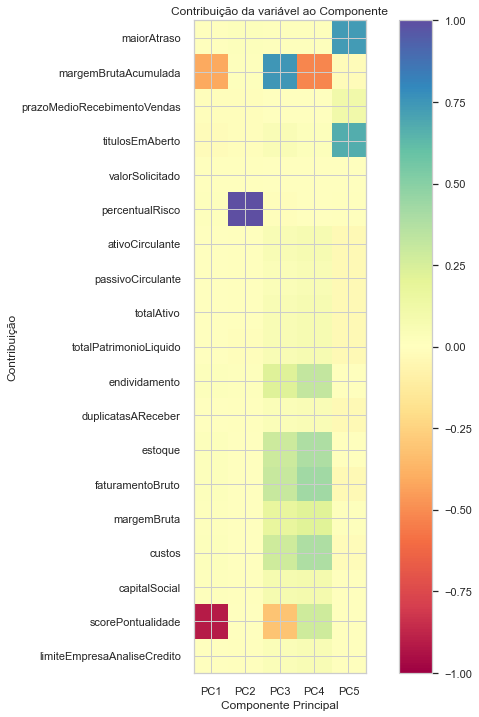

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap="Spectral", vmin=-1, vmax=1)
plt.yticks(range(len(df_mmsc.columns)), df_mmsc.columns)
plt.xticks(range(len(df_pca.columns)), df_pca.columns)
plt.xlabel("Componente Principal")
plt.ylabel("Contribuição")
plt.title("Contribuição da variável ao Componente")
plt.colorbar()

# Como decidir o K (número de clusters) para o Kmeans

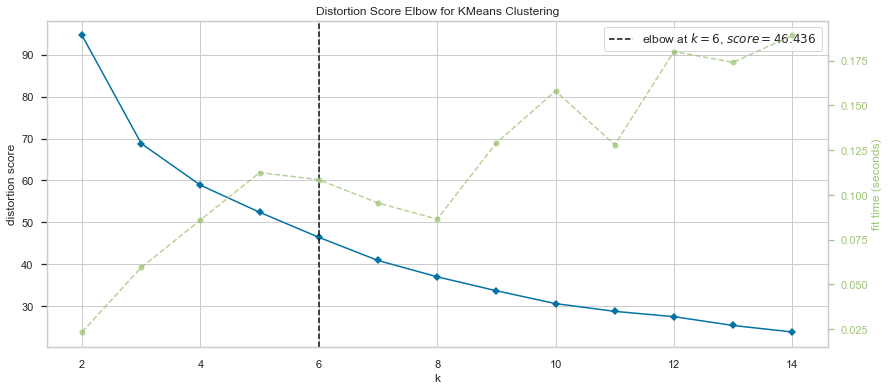

In [33]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

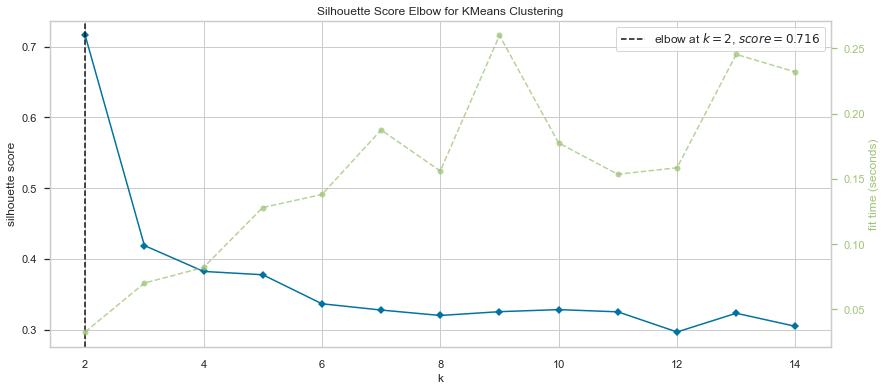

In [34]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, metric='silhouette',k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

In [35]:
fig = px.box(df_mmsc)
fig.show()

(0.1, 0.3)

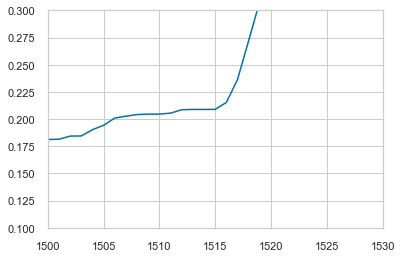

In [36]:
neighbors = NearestNeighbors(n_neighbors=44)
neighbors_fit = neighbors.fit(df_mmsc)
distances, indices = neighbors_fit.kneighbors(df_mmsc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlim(1500,1530)
plt.ylim(0.1,0.3)

In [37]:
km = KMeans(n_clusters=6, n_init=100)
km_labels = km.fit_predict(df_mmsc)

In [38]:
db = DBSCAN(eps=0.21, min_samples=44)
db_labels = db.fit_predict(df_mmsc)

In [39]:
df_num['kmeans'] = km_labels
df_mmsc['kmeans'] = km_labels
#df_pca['kmeans'] = km_labels
df['kmeans'] = km_labels
df['dbscan'] = db_labels

In [40]:
df.groupby('kmeans').maiorAtraso.count()

kmeans
0    188
1    410
2    321
3     47
4    425
5    132
Name: maiorAtraso, dtype: int64

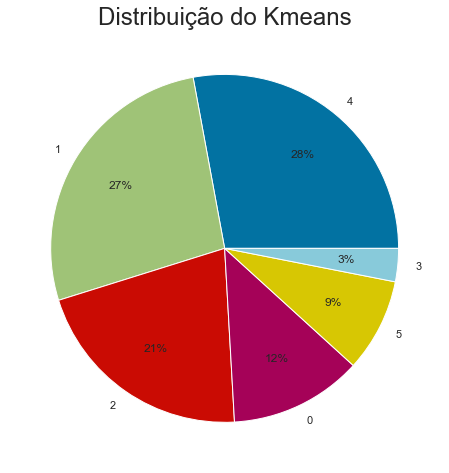

In [41]:
fig = plt.figure(figsize=(8,8))
df.kmeans.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)
plt.title('Distribuição do Kmeans', size=24)
plt.ylabel("")
plt.show()

In [42]:
df.groupby('dbscan').maiorAtraso.count()

dbscan
-1      61
 0     313
 1    1149
Name: maiorAtraso, dtype: int64

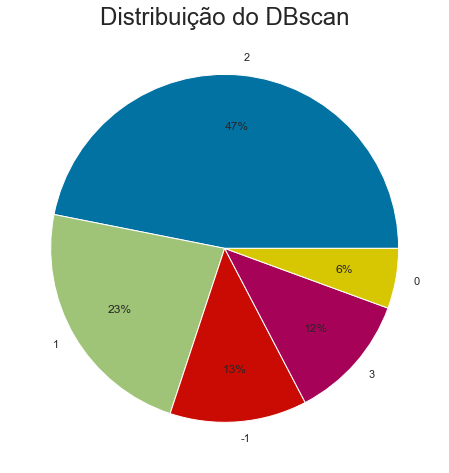

In [36]:
fig = plt.figure(figsize=(8,8))
df.dbscan.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)
plt.title('Distribuição do DBscan', size=24)
plt.ylabel("")
plt.show()

In [37]:
with pd.ExcelWriter("df_ex1_excel-4.xlsx") as writer:
    df.to_excel(writer)

In [43]:
#km_centroides = pd.DataFrame(mmsc.inverse_transform(pca.inverse_transform(km.cluster_centers_)))
km_centroides = pd.DataFrame(mmsc.inverse_transform(km.cluster_centers_))
km_centroides

,0,1,2,3,4
0,15.968085,0.004107,177.765957,0.145578,0.001330
1,16.199513,0.547047,55624.679781,0.170041,0.988296
2,22.265625,0.413847,33778.906219,0.374255,0.981653
3,79.319149,0.441882,47288.404894,0.273649,0.499965
4,29.240000,0.325780,62107.885835,0.153745,0.984699
5,17.272727,0.005721,81.527273,0.330436,0.002110


In [39]:
with pd.ExcelWriter("Kmeans_centroides-4.xlsx") as writer:
    km_centroides.to_excel(writer)

In [44]:
matriz = np.empty(km_centroides.shape)

for idc in range(km_centroides.shape[0]):
    for idx in range(km_centroides.shape[1]):
        num = [x for x in df_num.iloc[:,idx] if x < km_centroides.iloc[idc,idx]]
        num = round((len(num) / df_num.shape[0] *100), 2)
        matriz[idc,idx] = num
    

In [45]:
df_percentual = pd.DataFrame(matriz, columns=df_num.drop(['kmeans'], axis=1).columns)
df_percentual

,maiorAtraso,margemBrutaAcumulada,titulosEmAberto,percentualRisco,scorePontualidade
0,68.88,21.34,62.38,33.62,20.75
1,69.67,84.44,90.09,36.64,35.65
2,78.00,56.27,85.95,87.85,34.54
3,92.78,63.10,88.71,70.52,22.26
4,82.99,36.90,90.68,33.81,35.19
5,71.18,21.34,62.38,82.01,20.75


In [42]:
with pd.ExcelWriter("Kmeans_percentual-4.xlsx") as writer:
    df_percentual.to_excel(writer)

# Avaliação do Modelo

Vamos usar duas métricas para avaliar o modelo, e depois analisar algugns gráficos

The Davis-Bouldin Index is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.
The Silhouette Coefficient is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters.

In [46]:
print(f'Davies-Bouldin index = {davies_bouldin_score(df_mmsc, km_labels)}')
print(f'Silhouette Score = {silhouette_score(df_mmsc, km_labels)}')

Davies-Bouldin index = 0.3074096329722702
Silhouette Score = 0.8231973256091294


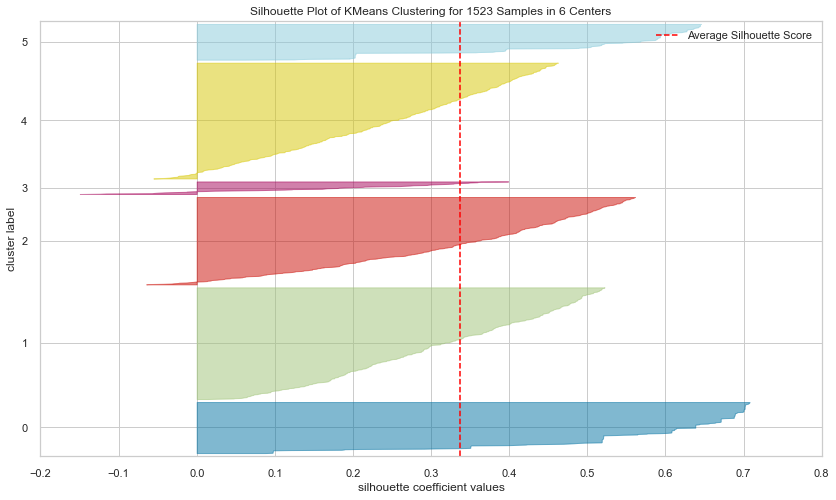

In [47]:
fig = plt.figure(figsize=(14,8))

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_mmsc.drop(['kmeans'],axis=1))
visualizer.show()
plt.show()

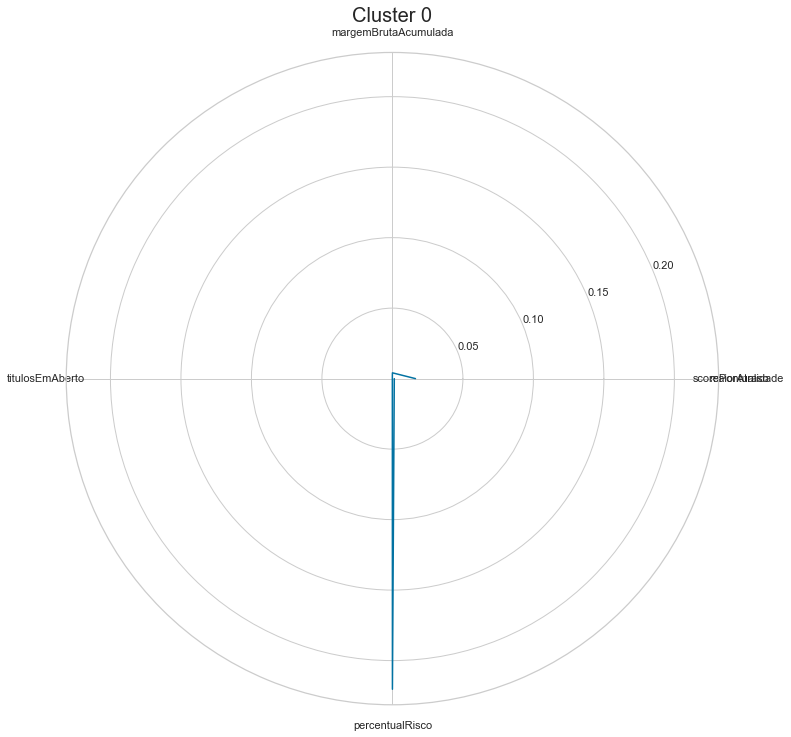

In [48]:
spider_plot(df_mmsc, 0)

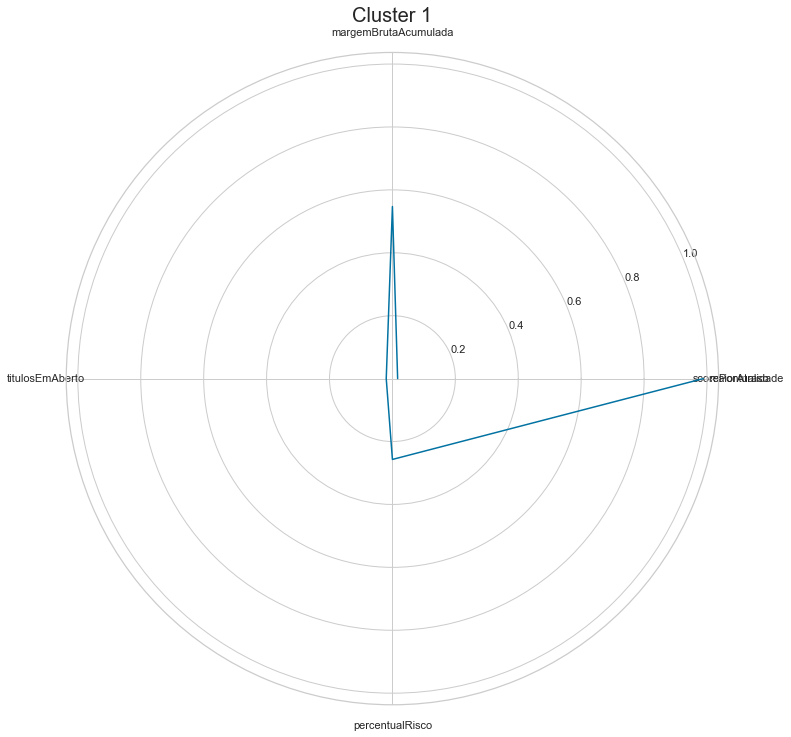

In [49]:
spider_plot(df_mmsc, 1)

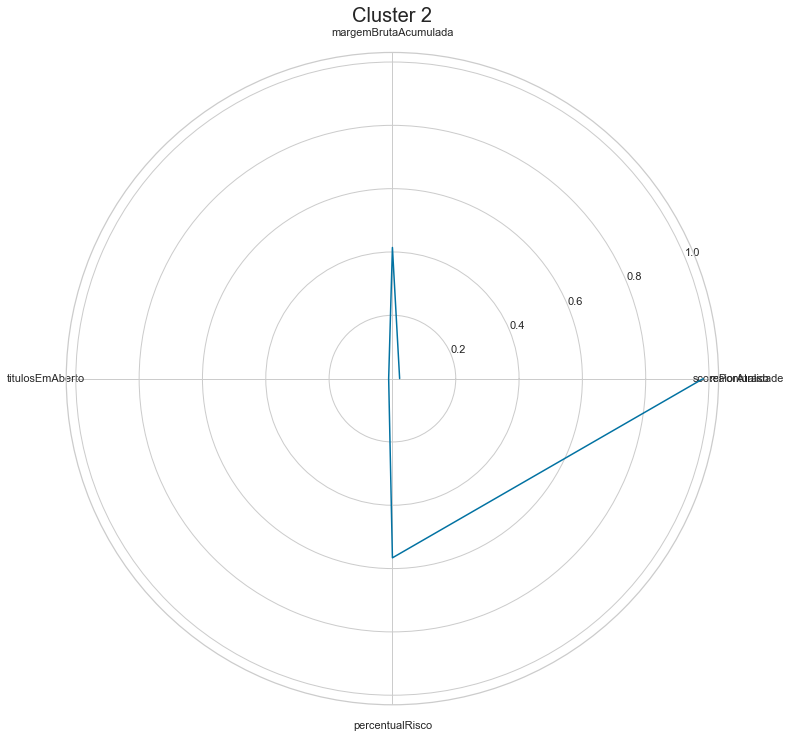

In [50]:
spider_plot(df_mmsc, 2)

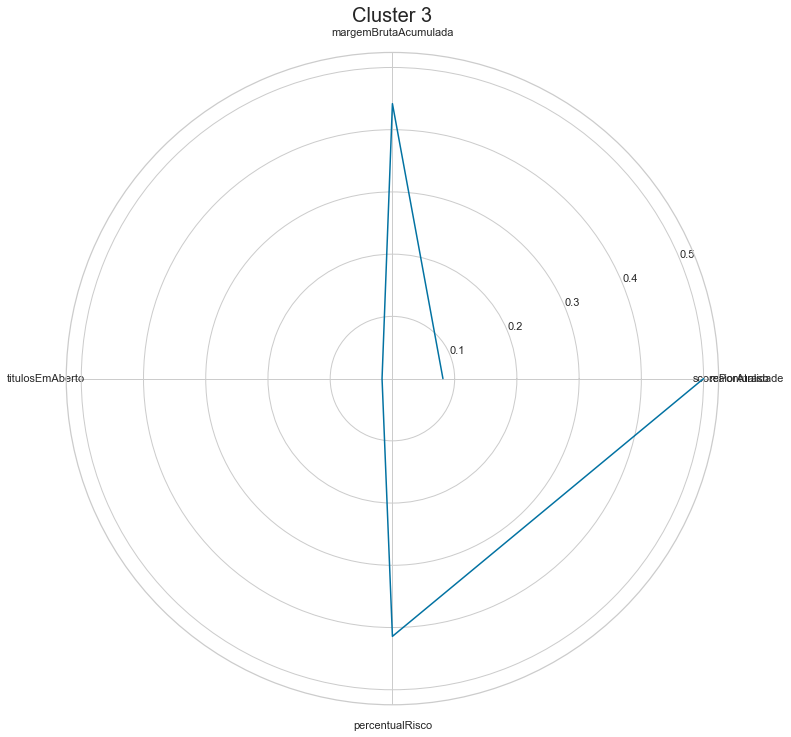

In [51]:
spider_plot(df_mmsc, 3)

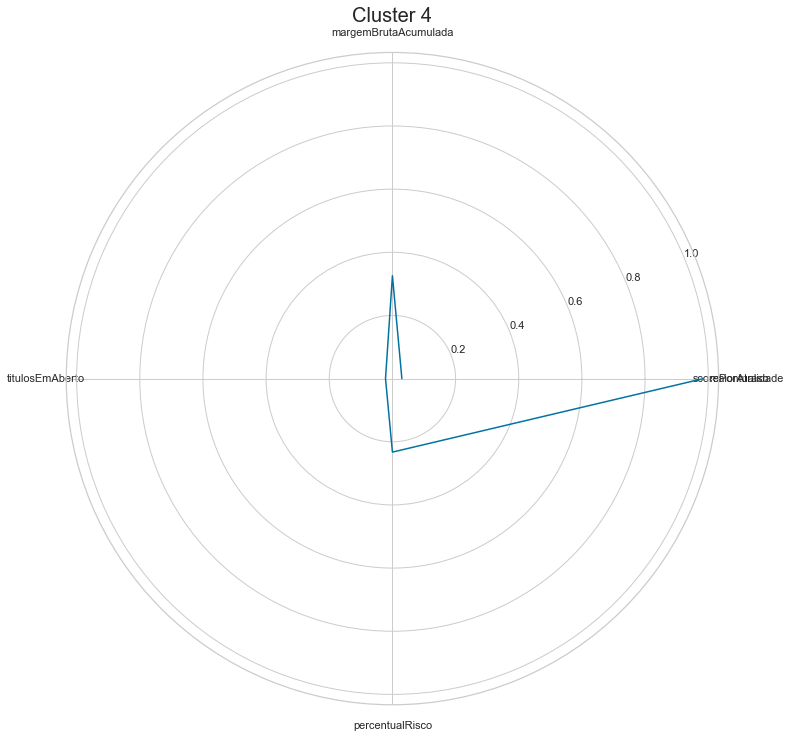

In [52]:
spider_plot(df_mmsc, 4)